In [1]:
!sudo apt update
%pip install -q -U python-dotenv
%pip install -q -U pdf2image
!sudo apt install --yes poppler-utils
%pip install -q -U openai
%pip install -q -U pytesseract
!sudo apt install --yes tesseract-ocr
%pip install -q -U Unidecode

Get:1 file:/var/cuda-repo-ubuntu2204-12-0-local  InRelease [1575 B]
Get:1 file:/var/cuda-repo-ubuntu2204-12-0-local  InRelease [1575 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]  
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:6 https://deb.nodesource.com/node_20.x nodistro InRelease [12.1 kB]        
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1153 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3108 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2314 kB]33m
Get:11 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.7 kB]
Get:12

In [2]:
import os
import json
from tqdm import tqdm
import re
from dotenv import load_dotenv
from urllib.parse import urlparse, urlunparse
import requests
from pdf2image import convert_from_path, convert_from_bytes
import tempfile
import unicodedata
from openai import OpenAI
import json
import os
import base64
from enum import Enum
from typing import List, Union, Literal, Optional
from pydantic import BaseModel
import pytesseract
from PIL import Image
from unidecode import unidecode
import urllib

In [4]:
load_dotenv()

OPENAI_API_KEY = os.environ["OPENAI_API_KEY_JS"]
WEIGHTS_AND_BIASES = os.environ["WEIGHTS_AND_BIASES"]

In [5]:
DATASET_PATH = "./documents"
PDF_PATH = os.path.join(DATASET_PATH, "german_pdf_files")
IMAGE_PATH = os.path.join(DATASET_PATH, "german_img_files")

In [6]:
with open(os.path.join(PDF_PATH, "mapping.json"), "r", encoding="utf8") as json_file:
    mappings_pdf = json.load(json_file)
    print("Current number of PDFs:", len(mappings_pdf))


with open(os.path.join(IMAGE_PATH, "mapping.json"), "r", encoding="utf8") as json_file:
    mappings_img = json.load(json_file)
    print("Current number of images:", len(mappings_img))

with open(
    os.path.join(DATASET_PATH, "extraction.json"), "r", encoding="utf8"
) as json_file:
    extraction = json.load(json_file)
    print("Current number of metadata extractions:", len(extraction))

Current number of PDFs: 18685
Current number of images: 16975
Current number of metadata extractions: 4547


In [7]:
del mappings_img["https://www.geo-iburg.de/Bergaufsicht.pdf"]

# Download Scraped PDF Files


In [ ]:
!wget https://digitalcorpora.s3.amazonaws.com/corpora/files/CC-MAIN-2021-31-PDF-UNTRUNCATED/metadata/cc-provenance-20230303.csv.gz
!gunzip --yes cc-provenance-20230303.csv.gz 

In [11]:
lines = []
with open("./cc-provenance-20230303.csv") as csv_file:
    for line in csv_file:
        lines.append(line)
header = lines[0]
content = lines[1:]

content = [line.split(",")[2] for line in content]


# filter all german urls
german_urls = []
for url in tqdm(content):
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    if hostname is None:
        continue
    if hostname.endswith("de"):
        german_urls.append(url)

len(german_urls)

100%|██████████| 8410703/8410703 [00:38<00:00, 216004.97it/s]


590954

In [8]:
download_count = 0

for url in tqdm(german_urls):
    if url in mappings_pdf:
        continue

    decoded_str = urllib.parse.unquote(url)
    parsed_url = urlparse(decoded_str)
    file_name = parsed_url.hostname + "_" + os.path.basename(parsed_url.path)
    if not file_name.endswith(".pdf"):
        continue

    try:
        response = requests.get(url, timeout=10)
    except:
        continue

    if response.status_code == 200:
        with open(os.path.join(PDF_PATH, file_name), "wb") as file:
            file.write(response.content)
            mappings_pdf[url] = file_name

        download_count += 1

        # Dump mapping to JSON file every 200 downloads
        if download_count % 200 == 0:
            with open(os.path.join(PDF_PATH, "mapping.json"), "w") as json_file:
                json.dump(mappings_pdf, json_file)

# Final dump of mapping to JSON file
with open(os.path.join(PDF_PATH, "mapping.json"), "w") as json_file:
    json.dump(mappings_pdf, json_file)

  7%|▋         | 41126/590954 [7:02:39<120:48:13,  1.26it/s]   7%|▋         | 41130/590954 [7:02:50<270:37:57,  1.77s/it]

# PDFs to Images


In [7]:
for url, file_name in tqdm(mappings_pdf.items()):
    if url in mappings_img:
        continue
    pdf_path = os.path.join(PDF_PATH, file_name)
    pdf_path = unicodedata.normalize("NFC", pdf_path)
    try:
        with tempfile.TemporaryDirectory() as path:
            image_data = convert_from_path(
                pdf_path, output_folder=path, fmt="jpeg", first_page=1, last_page=1
            )[0]
            image_data.save(os.path.join(IMAGE_PATH, file_name.replace(".pdf", ".jpg")))
            mappings_img[url] = file_name.replace(".pdf", ".jpg")
            with open(os.path.join(IMAGE_PATH, "mapping.json"), "w") as f:
                json.dump(mappings_img, f)
    except:
        continue

 44%|████▍     | 8267/18685 [18:08<49:24,  3.51it/s]     /usr/local/lib/python3.11/dist-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (130236672 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 51%|█████▏    | 9596/18685 [24:49<40:22,  3.75it/s]   /usr/local/lib/python3.11/dist-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (109134900 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 78%|███████▊  | 14605/18685 [50:57<19:50,  3.43it/s]   /usr/local/lib/python3.11/dist-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (108084000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 87%|████████▋ | 16199/18685 [1:00:24<09:05,  4.56it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (140171440 pixels) exceeds limit of 89478485 pixels, could be d

# Extract Metadata from Images


In [8]:
client = OpenAI(api_key=OPENAI_API_KEY)

In [9]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [10]:
class BaseEntity(BaseModel):
    type: str
    email: Optional[List[str]]
    phone: Optional[List[str]]
    fax: Optional[List[str]]
    address: Optional[str]
    website: Optional[str]


class Person(BaseEntity):
    type: Literal["person"]
    first_name: str
    last_name: Optional[str]
    role: Optional[str]
    mobile: Optional[List[str]]


class Government(BaseEntity):
    type: Literal["government"]
    department: str
    state: Optional[str]
    district: Optional[str]
    city: Optional[str]


class Company(BaseEntity):
    type: Literal["company"]
    name: str
    sector: Optional[str]


class Organisation(BaseEntity):
    type: Literal["organization"]
    name: str
    sector: Optional[str]


class Group(BaseEntity):
    type: Literal["group"]
    name: str


Entity = Union[Person, Government, Company, Organisation, Group]


class ContentType(str, Enum):
    presentation = "presentation"
    mail = "mail"
    newsletter = "newsletter"
    werbung = "werbung"
    einladung = "einladung"
    bewerbung = "bewerbung"
    ankündigung = "ankündigung"
    rechnung = "rechnung"
    brief = "brief"
    ausschreibung = "ausschreibung"
    nachrichten = "nachrichten"
    antrag = "antrag"
    angebot = "angebot"
    urkunde = "urkunde"
    sonstiges = "sonstiges"


class DocumentMetadata(BaseModel):
    title: str
    date: Optional[str]
    content_type: ContentType
    has_signature: bool
    main_author: Optional[Entity]
    other_authors: Optional[List[Entity]]
    logo_owners: Optional[List[str]]
    recipients: Optional[List[Entity]]

In [ ]:
for url in tqdm(list(mappings_img.keys())):

    if url in extraction:
        continue

    file_name = mappings_img[url]

    file_path = os.path.join(IMAGE_PATH, file_name)

    try:
        transcript = pytesseract.image_to_string(Image.open(file_path))
    except:
        continue

    base64_image = encode_image(file_path)

    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant. Your task is to extract metadata from documents. Structure your answer as clear as possible and be very precise and detailed in your answer.",
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"""
    Analysiere das folgende Dokument und extrahiere die wichtigsten Metadaten. Beantworte dabei die folgenden Punkte:

    0. Beschreibung des Dokuments (Inhalt, Form/Format, Auffälliges/Markantes, )

    1. Dokumententyp (wähle aus: Präsentation, E-Mail, Urkunde, Newsletter, Werbung, Einladung, Bewerbung, Ankündigung, Rechnung, Brief, Ausschreibung, Antrag, Sonstiges)

    2. Titel des Dokuments

    3. Datum des Dokuments

    4. Ist ein Logo vorhanden und deutet es auf eine Autorschaft hin?
    - Welche Firma / Person / Organisation ist Logoinhaber?

    5. Ist eine Unterschrift vorhanden, wenn ja von wem?

    6. Welche Entitäten (Person, Organisation, Behörde, ...) werden im Dokument genannt? In welchem Kontext werden sie genannt? Welche Rolle nehmen die Entitäten ein?

    7. Welche Entitäten könnten Autoren des Dokuments sein und warum? Welche dieser Entitäten werden explizit genannt?

    8. Welche Entitäten könnten Empfänger / Zielgruppe des Dokuments sein und warum? Welche dieser Entitäten werden explizit genannt?

    9. Liste alle Autoren oder Herausgeber.
        - Gib jede Entität (Person, Organisation, Behörde, ...) separat an
        - Füge Kontaktinformationen hinzu, falls verfügbar
        - Nenne ggf. die Verhältnisse der Entitäten zueinander

    10. Liste alle Empfänger.
        - Gib jede Entität (Person, Organisation, Behörde, ...) separat an
        - Füge Kontaktinformationen hinzu, falls verfügbar
        - Nenne ggf. die Verhältnisse der Entitäten zueinander

    11. Weitere relevante Metadaten des Dokuments

    Hier ist der Mitschrieb des zu analysierenden Dokuments:

    {transcript}

    Bitte antworte auf Deutsch und strukturiere deine Antwort entsprechend der obigen Punkte.
                        """,
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            },
        ],
    )

    unstructured_answer = response.choices[0].message.content

    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {
                "role": "system",
                "content": "Your task is to correctly format the given information. Integrate as much information as possible!",
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"{unstructured_answer} \n\n {transcript}",
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            },
        ],
        response_format=DocumentMetadata,
    )

    res = completion.choices[0].message.parsed

    res = res.dict()

    extraction[url] = {
        "unstructured": unstructured_answer,
        "transcript": transcript,
        "metadata": res,
    }

    with open(os.path.join(DATASET_PATH, "extraction.json"), "w", encoding="utf8") as f:
        json.dump(extraction, f)

# Examples


url: https://igbce.de/resource/blob/33564/f5017533031a4c18ea3b00af17390033/bveg-tarifinfo-2021-data.pdf


EXTRACTION:
{
    "title": "TARIFINFO",
    "date": "06.03.2020",
    "content_type": "newsletter",
    "has_signature": false,
    "main_author": {
        "type": "group",
        "email": [
            "info@igbce.de"
        ],
        "phone": [
            "0511 12345678"
        ],
        "fax": [
            "0511 12345679"
        ],
        "address": "Königsworther Platz 6, 30167 Hannover",
        "website": "www.igbce.de",
        "name": "Industriegewerkschaft Bergbau, Chemie, Energie (IG BCE)"
    },
    "other_authors": [
        {
            "type": "person",
            "email": null,
            "phone": null,
            "fax": null,
            "address": null,
            "website": null,
            "first_name": "Gabi",
            "last_name": "Kathmann",
            "role": "Mitglied der Tarifkommission",
            "mobile": null
        },
        {
 

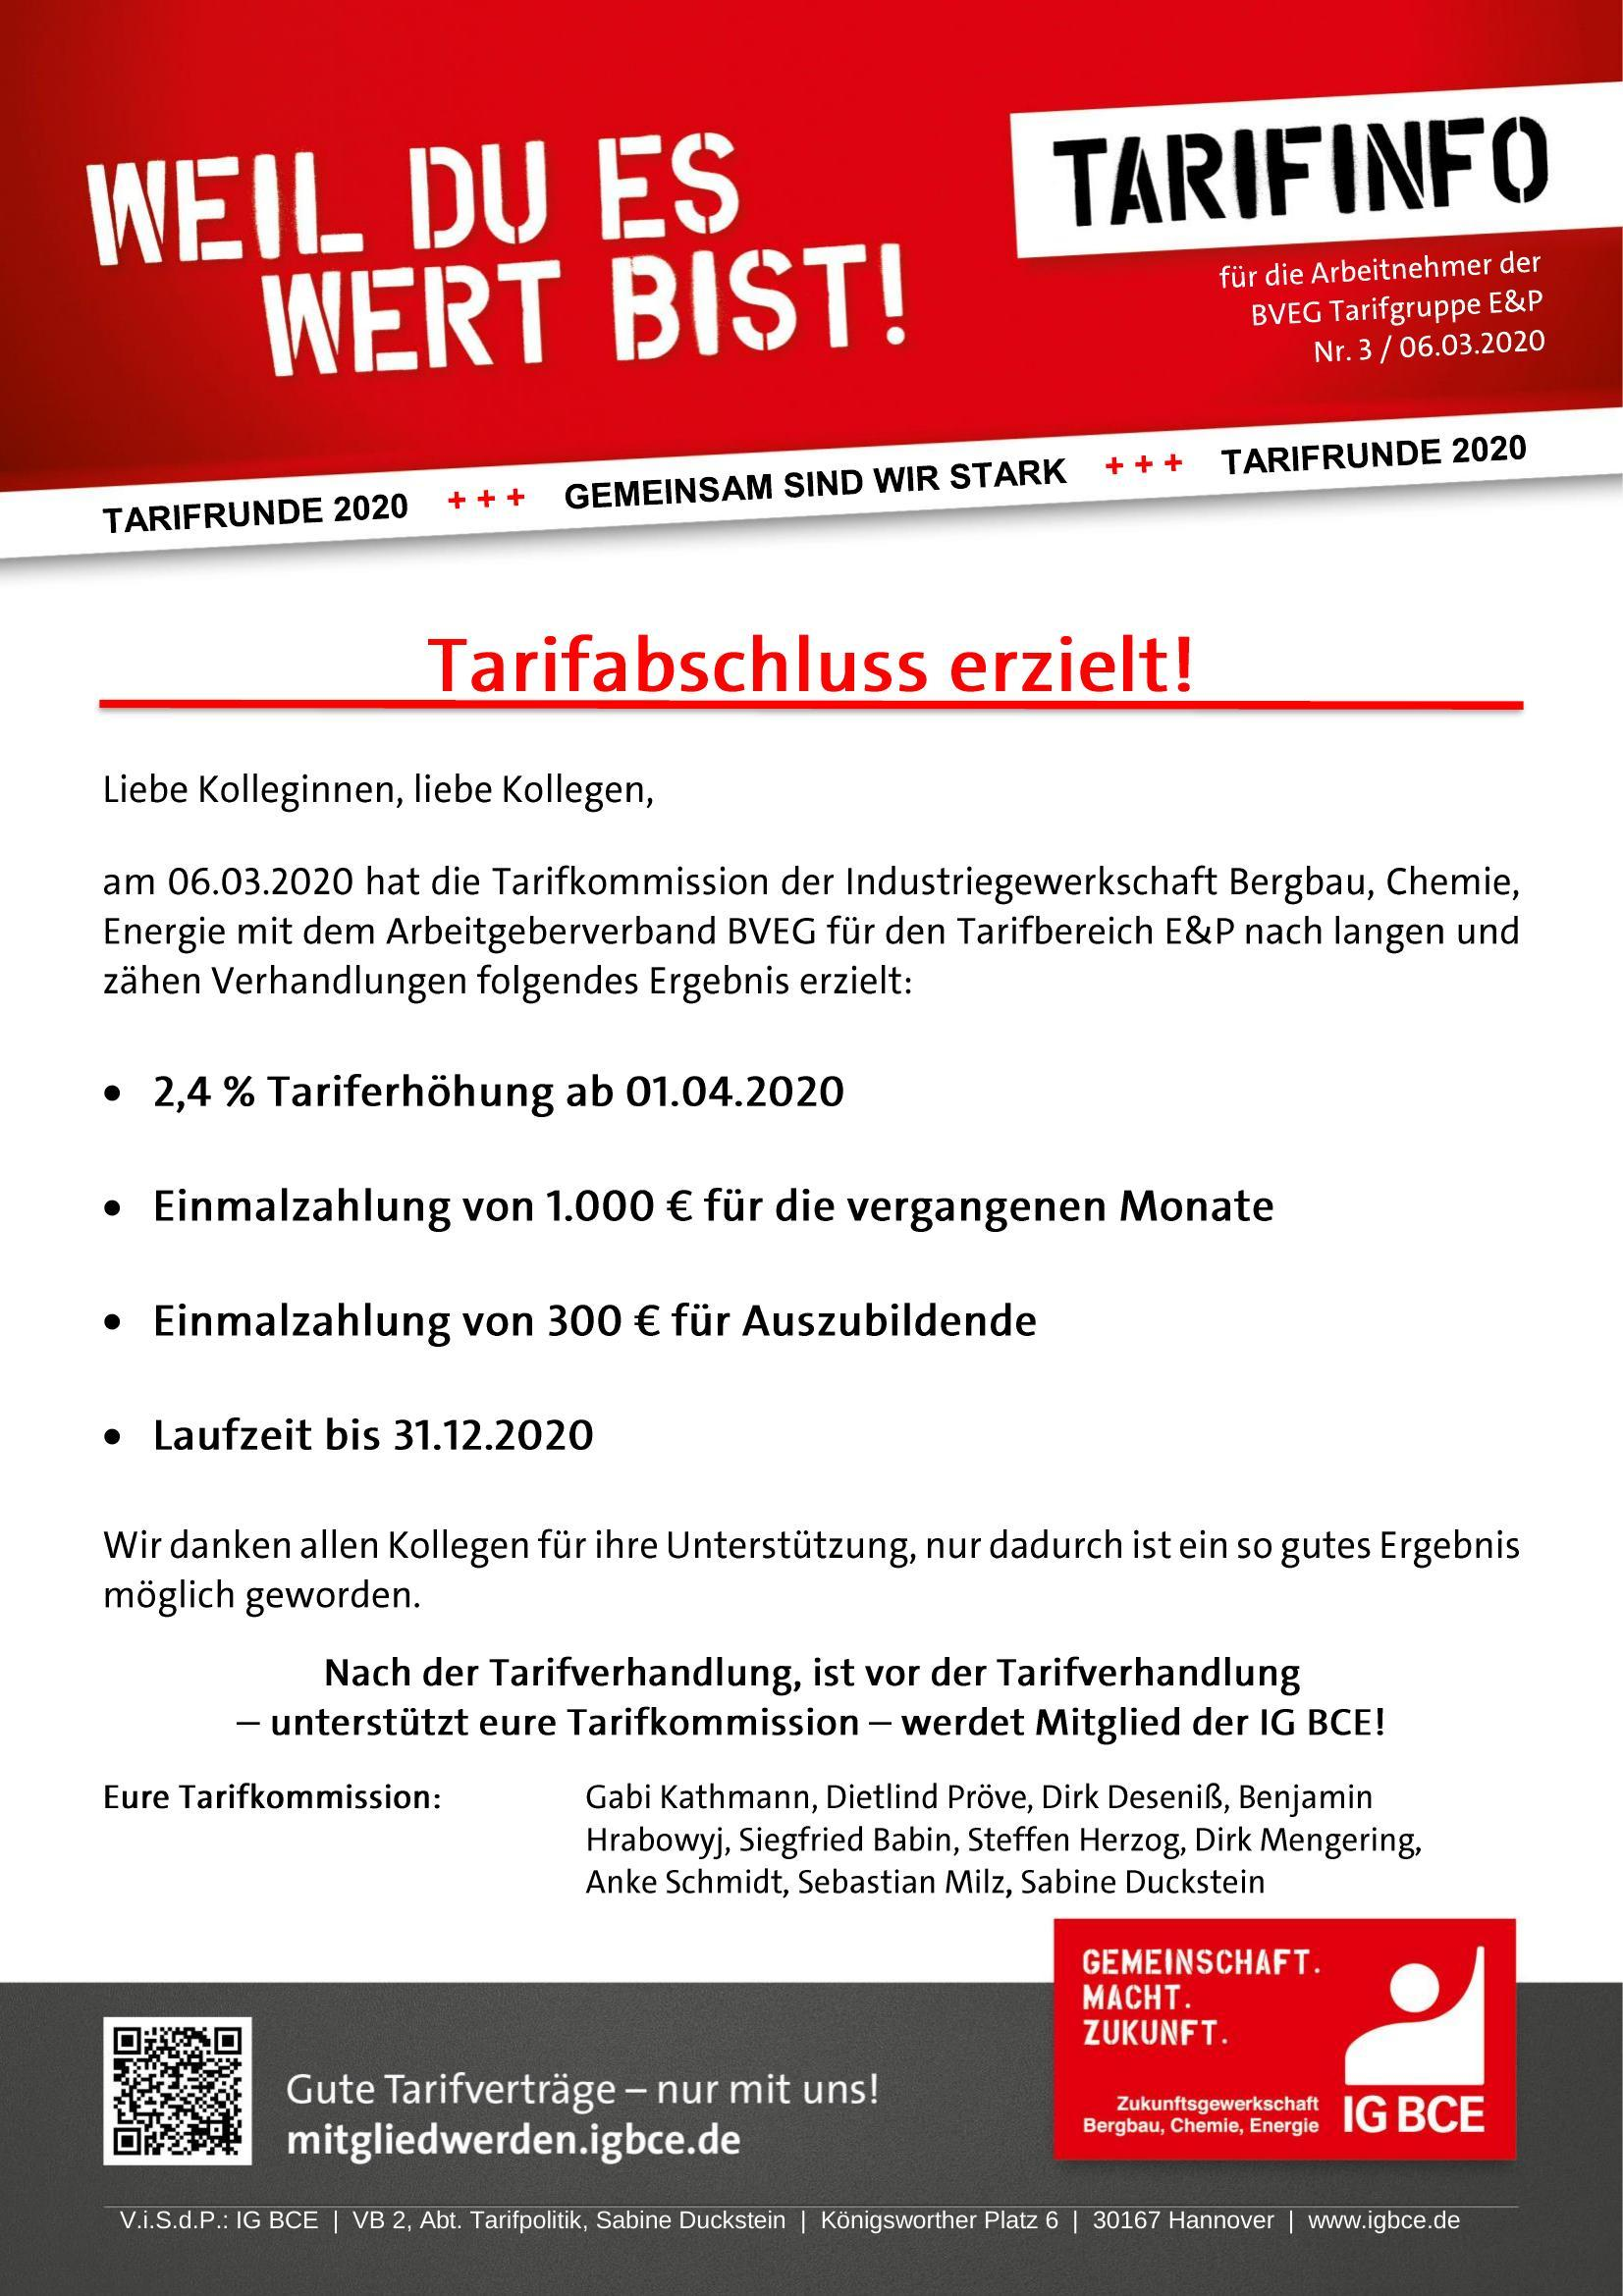

In [ ]:
url = list(extraction.keys())[0]
print("url:", url)
print("\n")
print("EXTRACTION:")
res = extraction[url]["metadata"]
print(json.dumps(res, indent=4, ensure_ascii=False))
from IPython.display import Image

file_name = mappings[url]
file_path = os.path.join(IMAGE_PATH, file_name)
Image(filename=file_path)

In [ ]:
print(extraction[url]["transcript"])
unstructured_answer

MKULM

ECK 4

RESTAURANT

KULMECK DAILY
07.07.2021 - 07.08.2021 // ab 16.00 Uhr

Vv

» Tomaten-Kokos-Suppe <
mit Safran & Chili
9 Euro

>» Currywurst <
meine Sauce, Croutons & Schnittlauch
10 Euro

» Jahrgangs Sardinen <
Knoblauchbrot & Tomatenchutney

16 Euro
nN
>» Pasta Parmesan < ——s
Vv

mit Pinienkernen & Rauke
18 Euro

> Bouillabaisse <«
Garnelen, Muscheln, Fisch & geréstetes Brot mit Safran-Aioli
20 Euro

>» NY famous Cheesecake «

Beeren, Rhabarber & Rahmeis
7 Euro

Wir freuen uns auf Ihren Besuch und bitten
um Anmeldung unter dining@kulmeck.de.

HERZLICH ILLKOMMEN!

 




'Hier sind die extrahierten Metadaten aus dem dokumentierten Inhalt:\n\n1. **Dokumententyp:** Sonstiges (Menü des Restaurants)\n\n2. **Titel des Dokuments:** KULMECK DAILY\n\n3. **Datum des Dokuments:** 07.07.2021 - 07.08.2021\n\n4. **Liste der Autoren oder Herausgeber:**\n   - **Entität:** Restaurant Kulmeck\n     - **Kontaktinformationen:** dining@kulmeck.de\n\n5. **Liste der Empfänger:**\n   - **Entität:** Allgemeine Gäste/Besucher des Restaurants\n     - **Kontaktinformationen:** keine spezifischen Informationen vorhanden\n\n6. **Ist eine Unterschrift vorhanden?** Ja (es gibt eine stilisierte Unterschrift)\n\n7. **Weitere relevante Metadaten des Dokuments:**\n   - **Zeiten:** Ab 16.00 Uhr\n   - **Gerichte mit Preisen:** Tomaten-Kokos-Suppe (9 Euro), Currywurst (10 Euro), Jahrgangs Sardinen (16 Euro), Pasta Parmesan (18 Euro), Bouillabaisse (20 Euro), NY famous Cheesecake (7 Euro)\n   - **Einladung zur Anmeldung:** Besucher werden um Anmeldung gebeten.\n\n8. **Confidence Level:** 9/

In [ ]:
print(unstructured_answer)

Hier sind die extrahierten Metadaten aus dem dokumentierten Inhalt:

1. **Dokumententyp:** Sonstiges (Menü des Restaurants)

2. **Titel des Dokuments:** KULMECK DAILY

3. **Datum des Dokuments:** 07.07.2021 - 07.08.2021

4. **Liste der Autoren oder Herausgeber:**
   - **Entität:** Restaurant Kulmeck
     - **Kontaktinformationen:** dining@kulmeck.de

5. **Liste der Empfänger:**
   - **Entität:** Allgemeine Gäste/Besucher des Restaurants
     - **Kontaktinformationen:** keine spezifischen Informationen vorhanden

6. **Ist eine Unterschrift vorhanden?** Ja (es gibt eine stilisierte Unterschrift)

7. **Weitere relevante Metadaten des Dokuments:**
   - **Zeiten:** Ab 16.00 Uhr
   - **Gerichte mit Preisen:** Tomaten-Kokos-Suppe (9 Euro), Currywurst (10 Euro), Jahrgangs Sardinen (16 Euro), Pasta Parmesan (18 Euro), Bouillabaisse (20 Euro), NY famous Cheesecake (7 Euro)
   - **Einladung zur Anmeldung:** Besucher werden um Anmeldung gebeten.

8. **Confidence Level:** 9/10 (hohe Sicherheit in d